In [22]:
import ROOT
import uproot
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import awkward as ak
from lmfit import minimize, Parameters, Model
import lmfit.models as models

In [5]:
#Funzioni utili
def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

def exponential(x, a, b, x0):
    return a*(np.exp(b*(x-x0))) 

def gauss_exp(x, A, mu, sigma, a, b, x0):
    return gaussian(x, A, mu, sigma) + exponential(x, a, b, x0)

def FermiDirac(x, N, A, x0):
    return N*(1/(1 + np.exp(A*(x0-x))))

def Spectrum_Shape(x, Cg, mu, sigma, Ce, b, x0, Cf, A, x1):
     return Cg* np.exp(-(x - mu)**2 / (2 * sigma**2)) + Ce*(np.exp(b*(x-x0))) + Cf*(1/(1 + np.exp(A*(x1-x))))

In [6]:
#importiamo i dati
#Tensione per considerare il segnale come saturato
Vt_all = np.array([-1.3, -1.3, -1.3, -1.3, -1.3, -1.3, -1.5, -1.3, 
               -1.3, -1.3, -1.3, -1.3, -1.3, -1.3, -1.3, -1.3]) #V
#Carica per filtrare spike ed eventi triggerati male
Q_max_all = np.array([-30, -30, -30, -30, -30, -30, -30, -30, 
                  -30, -30, -30, -30, -30, -30, -30, -30, ]) #pC
#Carica per filtrare cosmici
Q_min_all = np.array([-1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, 
                  -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, ]) #pC


In [7]:
channel=7
Vt = Vt_all[channel]
Q_max = Q_max_all[channel]
Q_min = Q_min_all[channel]

In [8]:
PATH = '../Dati/27_03/Run_ch7_Cs_Measurements_Only_3_27_2024_0000.root' #Percorso relativo del file da analizzare
RunCs = uproot.open(PATH) #Apertura file da analizzare

noise_file = '../Dati/Noises/ch' + str(channel) + '.root'  #File di rumore di riferimento per il canale
RunNoise = uproot.open(noise_file)  #Apertura rumore

#Eventi ripuliti su ch 7 = 883592
#Noise ripulita su ch 7 = 220636


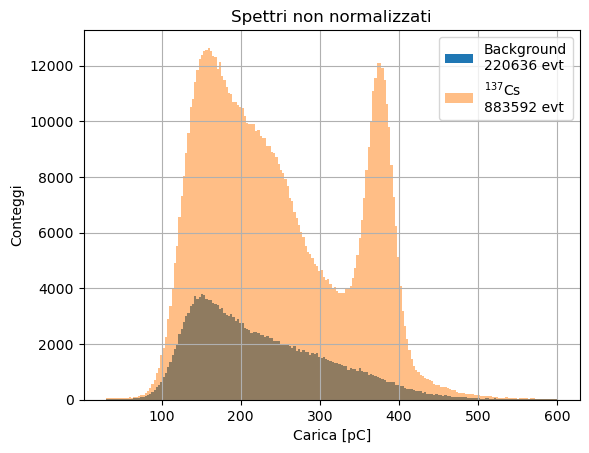

In [11]:
#Estrazione dati da file 

chargeCs = np.array(RunCs['tree'].arrays()['charge'])
ampCs = np.array(RunCs['tree'].arrays()['amp'])

chargeN = np.array(RunNoise['tree'].arrays()['charge'])
ampN = np.array(RunNoise['tree'].arrays()['amp'])

evCsT = np.array(RunCs['tree'].arrays()['ev'])[-1]
evNT = np.array(RunNoise['tree'].arrays()['ev'])[-1]

trueCs = ampCs>Vt  #Seleziono solo gli eventi che non saturano
chargeCs = chargeCs[trueCs]
ampCs=ampCs[trueCs]

trueCs = (chargeCs < Q_max) & (chargeCs > Q_min)
chargeCs = chargeCs[trueCs] #Seleziono solo gli eventi con una carica sotto una certa soglia
ampCs=ampCs[trueCs]         #così da trascurare spike ed eventi dovuti a trigger su altro canale


trueX = ampN>Vt             #Procedo allo stesso modo per "ripulire" il rumore
chargeN = chargeN[trueX]
ampN=ampN[trueX]

trueX = (chargeN < Q_max) & (chargeN > Q_min)
chargeN = chargeN[trueX]
ampN=ampN[trueX]

print("#Eventi ripuliti su ch " + str(channel) + " = " + str(len(chargeCs)))
print("#Noise ripulita su ch " + str(channel) + " = " + str(len(chargeN)))

bin = 200 #Binnaggio scelto?

#rendiamo le cariche positive
chargeCs=-chargeCs
chargeN=-chargeN

binN , edgeN , _= plt.hist(chargeN, bins=bin, range=(-Q_max, 600), 
                           density = False, label = "Background\n" + str(len(chargeN)) + " evt")

binCs, edgeCs, _ = plt.hist(chargeCs, bins=bin, range=(-Q_max, 600), 
                            density = False, label = r'$^{137}$Cs' + "\n" + str(len(chargeCs)) + " evt", alpha = 0.5)

plt.title("Spettri non normalizzati")
plt.ylabel("Conteggi")
plt.xlabel("Carica [pC]")
plt.grid()
plt.legend()
plt.show()

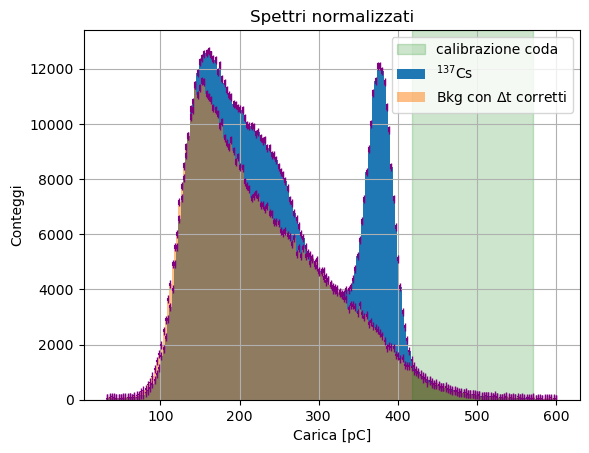

In [15]:
#Rinormalizzazione con integrale
rin_lim = [int(bin * 68/ 100), int(bin * 95 / 100)]
rin_f =  binCs[rin_lim[0]:rin_lim[1]].sum() / binN[rin_lim[0]:rin_lim[1]].sum()
binN_Ren = binN * rin_f #Moltiplicando per 1.5 viene molto meglio... mhhh

wdt = edgeN[1] - edgeN[0]
trash = plt.bar(edgeN[1:], binCs, width=wdt, label = r'$^{137}$Cs')
trash = plt.bar(edgeN[1:], binN_Ren, width=wdt, label = r'Bkg con $\Delta$t corretti', alpha = 0.5)

errCs = np.sqrt(binCs)
errN  = np.sqrt(binN_Ren)

trash = plt.errorbar(edgeN[1:], binN_Ren, errN, color='purple', fmt='|')
trash = plt.errorbar(edgeCs[1:], binCs, errCs, color='purple', fmt='|')

plt.axvspan(edgeN[rin_lim[0]], edgeN[rin_lim[1]], color='green', alpha=0.2, label = "calibrazione coda")


plt.title("Spettri normalizzati")
plt.ylabel("Conteggi")
plt.xlabel("Carica [pC]")
plt.grid()
plt.legend()
plt.savefig("../Fig/Spettri_Normalizzati_.png")
plt.show()


In [17]:
edgeN=edgeN[1:]

# Fit gaussiano sul picco per trovare i valori iniziali dei parametri

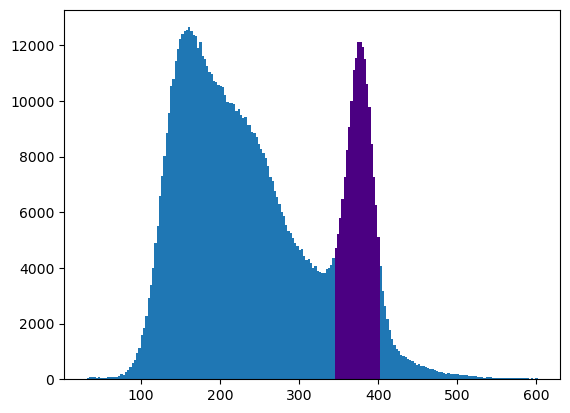

Valor medio = 374.7pC
Dev std = 14.3pC


/var/folders/17/9cj0cbps58xbmrl2zpj6hv2h0000gn/T/ipykernel_7948/1325344810.py:35: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(x_values, gaussian(x_values, *popt_gaus), 'r-', label='Fit: A=%5.3f, $\mu$=%5.3f, $\sigma$=%5.3f' % tuple(popt_gaus), ls = "-.")


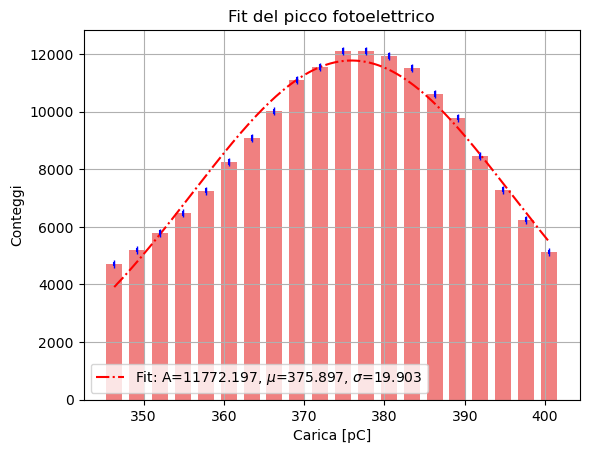

In [21]:
#limiti di integrazione picco fotoelettrico
photo_lim=[int(bin* 55/100), int(bin*65/100)]


trash = plt.bar(edgeN, binCs, width=wdt, label = r'$^{137}$Cs')
trash = plt.bar(edgeN[photo_lim[0]:photo_lim[1]], binCs[photo_lim[0]:photo_lim[1]], width=wdt, label = r'$^{137}$Cs', color='indigo')

plt.show()
edge_photo=edgeN[photo_lim[0]:photo_lim[1]]
counts_photo=binCs[photo_lim[0]:photo_lim[1]]
err_photo=errCs[photo_lim[0]:photo_lim[1]]

bin_centers=edge_photo
# Calcoliamo il valore rappresentativo pesato dai conteggi di ciascun bin
weighted_values = bin_centers * counts_photo

# Calcoliamo la media pesata
weighted_mean = np.sum(weighted_values) / np.sum(counts_photo)

# Calcoliamo la deviazione standard pesata
weighted_std = np.sqrt(np.sum(counts_photo * (bin_centers - weighted_mean)**2) / np.sum(counts_photo))

print("Valor medio = " + str(round(weighted_mean, 1)) + "pC")
print("Dev std = " + str(round(weighted_std, 1)) + "pC")



# Facciamo il fit della gaussiana ai dati
popt_gaus, pcov_gaus = curve_fit(gaussian, bin_centers, counts_photo, p0=[1, weighted_mean, weighted_std], sigma=err_photo,
                        maxfev = 5000)

# Plot dell'istogramma e della curva di fit
plt.bar(edge_photo,counts_photo,width=2, color = "lightcoral")
x_values=np.linspace(np.min(edge_photo), np.max(edge_photo), 200)
plt.plot(x_values, gaussian(x_values, *popt_gaus), 'r-', label='Fit: A=%5.3f, $\mu$=%5.3f, $\sigma$=%5.3f' % tuple(popt_gaus), ls = "-.")
plt.errorbar(edge_photo, counts_photo, err_photo, color='blue', fmt='|')
plt.legend()
plt.xlabel('Carica [pC]')
plt.ylabel('Conteggi')
plt.title("Fit del picco fotoelettrico")
plt.grid()
plt.savefig("../Fig/Picco_Cs.png")
plt.show()

In [41]:
#definiamo l'intervallo in cui vogliamo fittare o spettro, idealmente fotoelettrico + un po'di spalla Compton

bin_lims = [int(bin *15 / 100), int(bin * 58 / 100)]
_, edges, _ = plt.hist(chargeCs, bins = bin, color = "r")
plt.clf()
lims = [edges[bin_lims[0]], edges[bin_lims[1]]]
binCs, edgesCs, _ = plt.hist(chargeCs, bins = bin, range = lims, color = "b", alpha = 0.5)

lims_counts=[binN_Ren[bin_lims[0]], binN_Ren[bin_lims[1]]]

plt.show()

SyntaxError: invalid syntax (470527896.py, line 6)

In [40]:
lims

[174.53289794921875, 588.7373046875]

In [ ]:
centersN = np.convolve(edgeN, [0.5, 0.5], "valid")
errN = np.sqrt(binN)
plt.errorbar(centersN, binN, errN, color = "red", fmt='|')
plt.show()

# Fit al rumore rinormalizzato per dargli i valori di partenza

In [38]:
# Create an lmfit Model using the custom function
exp = models.ExponentialModel(prefix='e1')
#sh_exp.prefix = "exp"
gauss1 = models.GaussianModel(prefix='g1_')


###################################
# Set initial parameter values and bounds
params = exp.make_params(amplitude = 171, decay = -10)
#params['amplitude'].min = 0  # Ensure amplitude is positive
#params['decay'].max = 0  # Ensure decay rate is negative

params.update(gauss1.make_params(center=dict(value=-275, min=-450, max=-150),
                               sigma=dict(value=86, min=0),
                               amplitude=dict(value=20, min=0)))

model = exp + gauss1

###########
centersN = np.convolve(edgeN, [0.5, 0.5], "valid")
errN = np.sqrt(binN)
# Fit the model to the data
result = model.fit(binN, params, x = centersN, weights = 1 / errN)

# Plot the data and the fitted model
#plt.plot(, y_noisy, 'bo', label='Data')
#plt.plot(centersN, result.best_fit, 'r-', label='Fit')

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.hist(chargeN, bins = bin, range = lims, color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Charhe [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result.eval_components()
ax1.plot(centersN, result.best_fit, label='best fit')
ax1.plot(centersN, comps['shifted_exponential'], label='exp')
ax1.plot(centersN, comps['g1_'], label='gauss')
ax1.legend()

ax1.errorbar(centersN, binN, errN, color = "red", fmt='|')
ax1.grid()

residueN = result.best_fit - binN
norm_resN = residueN / errN

ax2.errorbar(centersN, norm_resN, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charhe [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()
ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()

fig.tight_layout()

plt.show()


# Print fit statistics and parameter values
print(result.fit_report())


ValueError: operands could not be broadcast together with shapes (199,) (200,) 